### 03 앙상블 학습
**앙상블 학습 개요**

- 여러 개의 분류기를 생성하고 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법
- 보팅(Voting), 배깅(Bagging), 부스팅(Boosting)
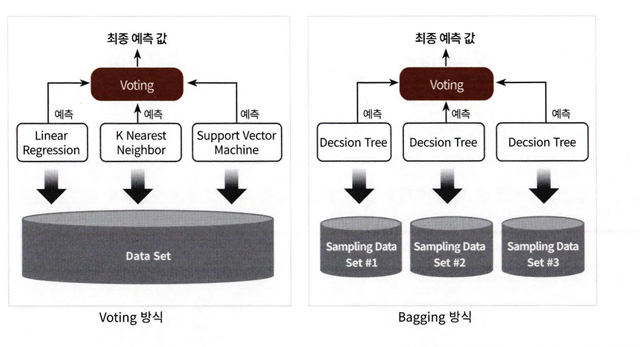


**보팅 유형 - 하드 보팅(Hard Voting)과 소프트 보팅(Soft Voting)**
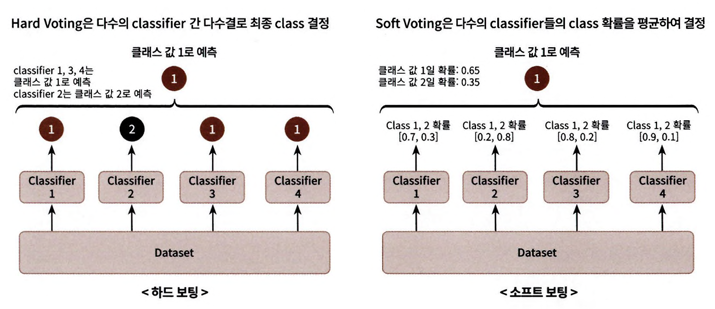

**보팅 분류기(Voting Classifier)**

In [ ]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [ ]:
# 개별 모델은 로지스틱 회귀와 KNN임.
lr_clf = LogisticRegression(solver = "liblinear")
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf= VotingClassifier(estimators=[('LR', lr_clf),('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가.
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_test)
  class_name = classifier.__class__.__name__
  print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


---
### 04 랜덤 포레스트
**랜덤 포레스트의 개요 및 실습**

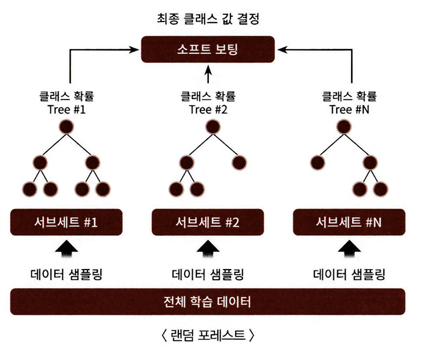

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                              'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                  if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [ ]:
import pandas as pd

def get_human_dataset( ):

    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('/content/drive/MyDrive/ESAA/data/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('/content/drive/MyDrive/ESAA/data/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('/content/drive/MyDrive/ESAA/data/X_test.txt',sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('/content/drive/MyDrive/ESAA/data/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('/content/drive/MyDrive/ESAA/data/y_test.txt',sep='\s+',header=None,names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)
pred =rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9220


**램덤 포레스트 하이퍼 파라미터 및 튜닝**
-  단점: 하이퍼 파라미터가 너무 많고 그로 인해서 튜닝을 위한 시간이 많이 소모됨.
  -  n_estimaotrs: 랜덤 포레스트에서 결정 트리의 개수를 지정, 디폴트는 10개이므로 많이 설정할수록 좋은 성능을 기대할 수 있지만 계속 증가시킨다고 성능이 무조건 향상되는 것은 아님, 또한 늘릴수록 학습 수행 시간이 오래 걸리는 것도 감안해야 함.
  - max_features는 결정 트리에 사용된 max_features 파라미터와 같음, 하지만, RandomForestClassifier의 기본 max_features는 'None'이 아니라 'auto', 즉 'sqrt'와 같음. 따라서 랜덤 포레스트의 트리를 분할하는 피처를 참조할 때 전체 피처가 아니라 sqrt(전체 피처 개수)만큼 참조함(전체 피처가 16개라면 분할을 위해 4개 참조)
  - max_depth나 min_samples_leaf, min_samples_split와 같이 결정 트리에서 과적합을 개선하기 위해 사용되는 파라미터가 랜덤 포레스트에도 똑같이 적용될 수 있음.


In [ ]:
from sklearn.model_selection import GridSearchCV

params={
    'max_depth':[8,16,24],
    'min_samples_leaf': [1,6,12],
    'min_samples_split':[2,8,16]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도: 0.9165


In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16,
                                 min_samples_split=2, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9260


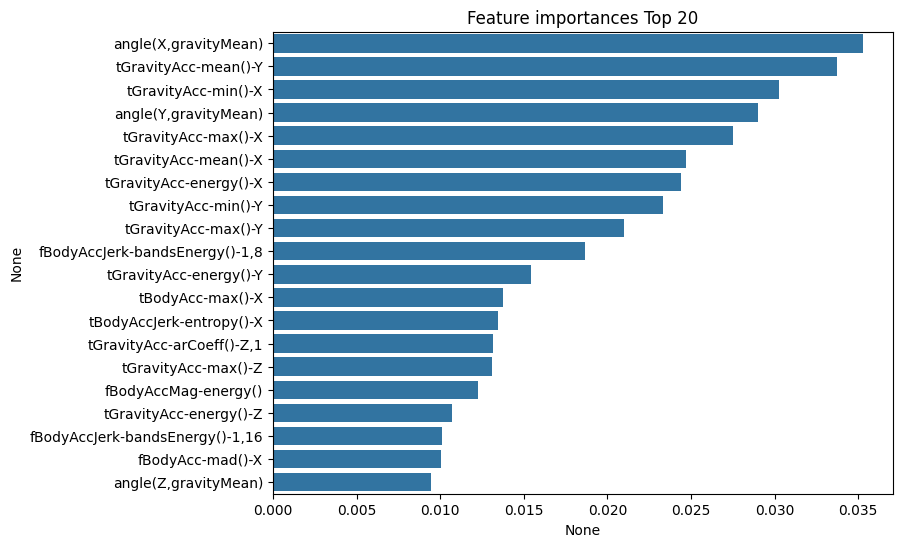

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

### 05 GBM(Gradient Boosting Machine)
**GBM의 개요 및 실습**

-  step1은 첫번째 약한 학습기(weak learner)가 분류 기준 1로 +와 -를 분류한 것임. 동그라미로 표시된 + 데이터는 + 데이터가 잘못 분류된 오류 데이터 임.
- step2에서는 이 오류 데이터에 대해서 가중치 값을 부여, 가중치가 부여된 오류 + 데이터는 다음 약한 학습기가 더 잘 분류할 수 있게 크기가 커짐.
- step3은 두번째 약한 학습기가 분류 기준 2로 +와 -를 분류했음. 마찬가지로 동그라미로 표시된 - 데이터는 잘못 분류된 오류 데이터임.
- step4에서는 잘못 분류된 이 - 오류 데이터에 대한 다음 액한 학습기가 잘 분류할 수 있게 더 큰 가중치를 부여함.(오류 - 데이터의 크기가 커짐)
- step5는 세번쨰 약한 학습기가 분류기준 3으로 + -를 분류하고 오류 데이터를 찾음. 에이다 부스트는 이렇게 약한 학습기가 순차적으로 오류 값에 대해 가중치를 부여한 예측 결정 기준을 모두 결합해 예측을 수행

- 마지막으로 맨 아래에는 첫번째, 두번쨰, 세번쨰 약한 학습기를 모두 결합한 결과 예측임. 개별 약한 학습기보다 훨씬 정확도가 높아졌음

- GBM은 CART 기반의 다른 알고리즘과 마찬가지로 분류, 회귀 가능

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위한 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f}초'.format(time.time()-start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 1653.0초


**GBM 하이퍼 파라미터 소개**

-  loss: 경사 하강법에서 사용할 비용 함수를 지정, 특별한 이유가 없으면 기본값인 'deviance'르 그대로 적용
- learning_rate: GBM이 핛브을 진행할 때마다 적용하는 학습률, weak learner가 순차적으로 오류 값을 보정해 나가는데 적용하는 계수로 0~1 사이의 값을 지정 가능하며 기본 값이 0.1임.
- n_etimators: weak learner의 개수로 weak learner가 순차적으로 오류를 보정하므로 개수가 많을 수록 예측 성능이 일ㅈ어 수준까지는 좋아질 수 있음. 하지만 개수가 많을 수록 예측 성능이 일정 수준까지는 좋아 질 수 있지만 개수가 많을 수록 수행 시간이 오래 걸림. 기본값은 100임.
- subsample: weak learner가 학습에 사용하는 데이터 샘플링의 비율로 기본값은 1이며, 이는 전체 학습 데이터를 기반으로 학습한다는 의미


### 06 XGBoost(eXtra Gradient Boost)
**XGBoost 개요**
- GBM의 단점인 느린 수행 시간 및 과적합 규제 부재 등의 문제를 해결 가능
- 병렬 CPU 환경에서 병렬 학습이 가능해 기존 GBM보다 빠르게 학습을 완료할 수 있음.
- Tree pruning: 더 이상 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 더 줄임.
- 자체 내장되 교차 검증: 반복 수행 시마다 내부적으로 학습 데이터 세트와 평가 데이터 세트에 대한 교차 검증을 수행해 최적화된 반복 수행 횟수를 가질 수 있음, 지정된 반복 횟수가 아니라 교차 검증을 통해 평가 데이터 세트의 평가 값이 최적화 되면 반복을 중간에 멈출 수 있는 조기 중단 기능이 있음.
- 결손값 자체 처리: XGBoost는 결손값을 자체 처리할 수 있는 기능을 가지고 있음.

In [ ]:
# XGBoost 설치하기
!pip install xgboost==1.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.1
    Uninstalling xgboost-2.1.1:
      Successfully uninstalled xgboost-2.1.1


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

**파이썬 래퍼 XGBoost 하이퍼 파라미터**
- 일반 파라미터: 일반적으로 실행 시 스레드의 개수나 slient 모드 등의 선택을 위한 파라미터로서 디폴트 파라미터 값을 바꾸는 경우는 거의 없음
- 부스트 파라미터: 트리 최적화, 부스팅, regularization 등과 관련 파라미터 지칭.
- 학습 태스크 파라미터: 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터
- 주요 일반 파라미터
  - booster: gbtree(tree based model) 또는 gblinear(linear model) 선택, 디폴트는 gbtree임.
  - slient: 디폴트는 0이며, 출력 메세지를 나타내고 싶지 않을 경우 1로 설정
  - nthread: CPU의 실행 스레드 개수를 조정하며, 디폴트는 CPU의 전체 스레드를 다 사용하는 것임.

- 과적합 문제가 심각할 경우
   - eta 값을 낮춤(0.01 ~ 0.1) eta 값을 낮출 경우 num_round(또는 n_estimators)는 반대로 높여줘야 함.
   - max_depth 값을 낮춤
   - min_child_weight 값을 높임
   - gamma 값을 높임
   - 또한 subsample과 colsample_bytree를 조정하는 것도 트리가 너무 복잡하게 생성되는 것을 막아 과적합 문제에 도움이 됨.
   

In [ ]:
import xgboost
print(xgboost.__version__)

1.5.0


**파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측**


In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df  = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [ ]:
# cancer_df에서 feature용 DataFrame과 label용 Series 객체추출
# 맨 마지막 칼럼이 label임. feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째
# 칼럼까지를:-1 슬라이싱으로 추출.
X_feature = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_label, test_size=0.2,
                                                    random_state=156)
# 위에서 만든 X_train, y_trian을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1,
                                            random_state=156)
print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [ ]:
# 만약 구버전 XGBoost에서 DataFrmae으로 DMatrix 생성이 안 될 경우 X_train.values로 넘파이 변환.
# 학습, 검증, 테스트용 DMatrix 생성.
dtr = xgb.DMatrix(data=X_tr.values, label=y_tr.values)
dval = xgb.DMatrix(data=X_val.values, label=y_val.values)
dtest = xgb.DMatrix(data=X_test.values, label=y_test.values)

- max_depth(트리 최대 깊이)는 3.
- 학습률 eta는 0.1(XGBClassifier를 사용할 경우 eta 아니라 learning_rate 임)
- 예제 데이터가 0 또는 1 이진 분류이므로 목적함수(objective)는 이진 로지스틱(binary:logistic).
- 오류 함수의 평가 성능 지표는 logloss
- num_rounds(부스팅 반복 횟수)는 400회


In [ ]:
params = {'max_depth': 3,
          'eta': 0.1,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss'}
num_rounds= 400

In [ ]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval'로 명기함.
eval_list = [(dtr, 'train'),(dval,'eval')] # 또는 eval_list = [(dval,'eval')]만 명기해도 무방.

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달.
xgb_model = xgb.train(params, dtrain=dtr, num_boost_round=num_rounds, \
                      early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.60931	eval-logloss:0.63234
[1]	train-logloss:0.54033	eval-logloss:0.59134
[2]	train-logloss:0.48245	eval-logloss:0.55548
[3]	train-logloss:0.43082	eval-logloss:0.51440
[4]	train-logloss:0.38662	eval-logloss:0.48186
[5]	train-logloss:0.35031	eval-logloss:0.46087
[6]	train-logloss:0.31681	eval-logloss:0.43670
[7]	train-logloss:0.28716	eval-logloss:0.41290
[8]	train-logloss:0.26204	eval-logloss:0.39283
[9]	train-logloss:0.23912	eval-logloss:0.37862
[10]	train-logloss:0.21881	eval-logloss:0.36538
[11]	train-logloss:0.20090	eval-logloss:0.35174
[12]	train-logloss:0.18450	eval-logloss:0.33945
[13]	train-logloss:0.16993	eval-logloss:0.33112
[14]	train-logloss:0.15687	eval-logloss:0.32188
[15]	train-logloss:0.14536	eval-logloss:0.31217
[16]	train-logloss:0.13488	eval-logloss:0.30588
[17]	train-logloss:0.12530	eval-logloss:0.30019
[18]	train-logloss:0.11670	eval-logloss:0.29251
[19]	train-logloss:0.10906	eval-logloss:0.28847
[20]	train-logloss:0.10228	eval-logloss:0.28341
[2

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시')
print(np.round(pred_probs[:10],3))
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 10개만 표시, 예측 확률 값으로 표시
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시
[0.882 0.005 0.654 0.075 0.981 0.999 0.999 0.999 0.997 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9930


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

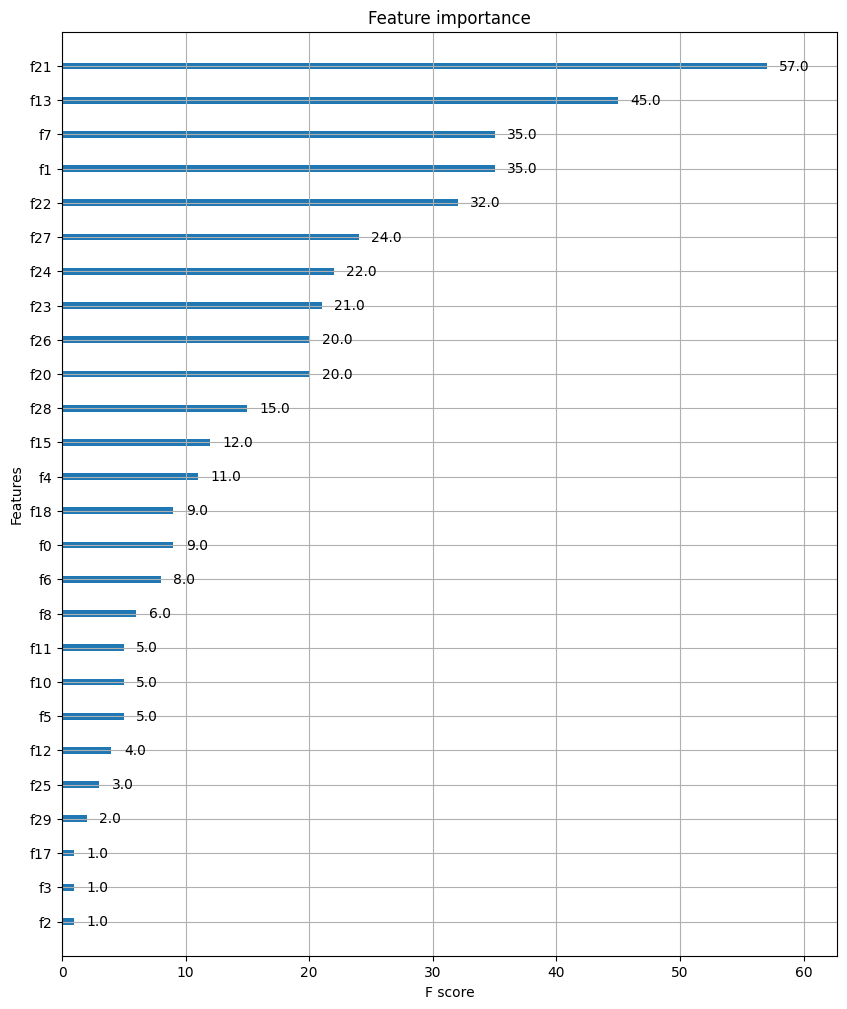

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

- 파라미터 설명
  - params (dict): 부스터 파라미터
  - dtriain (DMatrix): 학습 데이터
  - num_boost_round (int): 부스팅 반복 횟수
  - nfold (int): CV 폴드 개수.
  - stratified (bool): CV 수행 시 층화 표본 추출(stratified sampling) 수행 여부
  - metrics(string or list of strings): CV 수행시 모니터링할 성능 평가 지표
  - early_stopping_rounds (int): 조기 중단을 활성화시킴. 반복 횟수 지정
  

**사이킷런 래퍼 XBoost의 개요 및 적용**

In [ ]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

# Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력.
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train.values, y_train.values, verbose=True)

w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [ ]:
get_clf_eval(y_test,w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr.values, y_tr.values), (X_val.values, y_val.values)]
xgb_wrapper.fit(X_tr.values, y_tr.values, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52929
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31893	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

In [ ]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9933


In [ ]:
# early_stopping_rounds를 10으로 설정하고 재학습.
xgb_wrapper.fit(X_tr.values, y_tr.values, early_stopping_rounds=10,
                eval_metric='logloss', eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52929
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31893	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

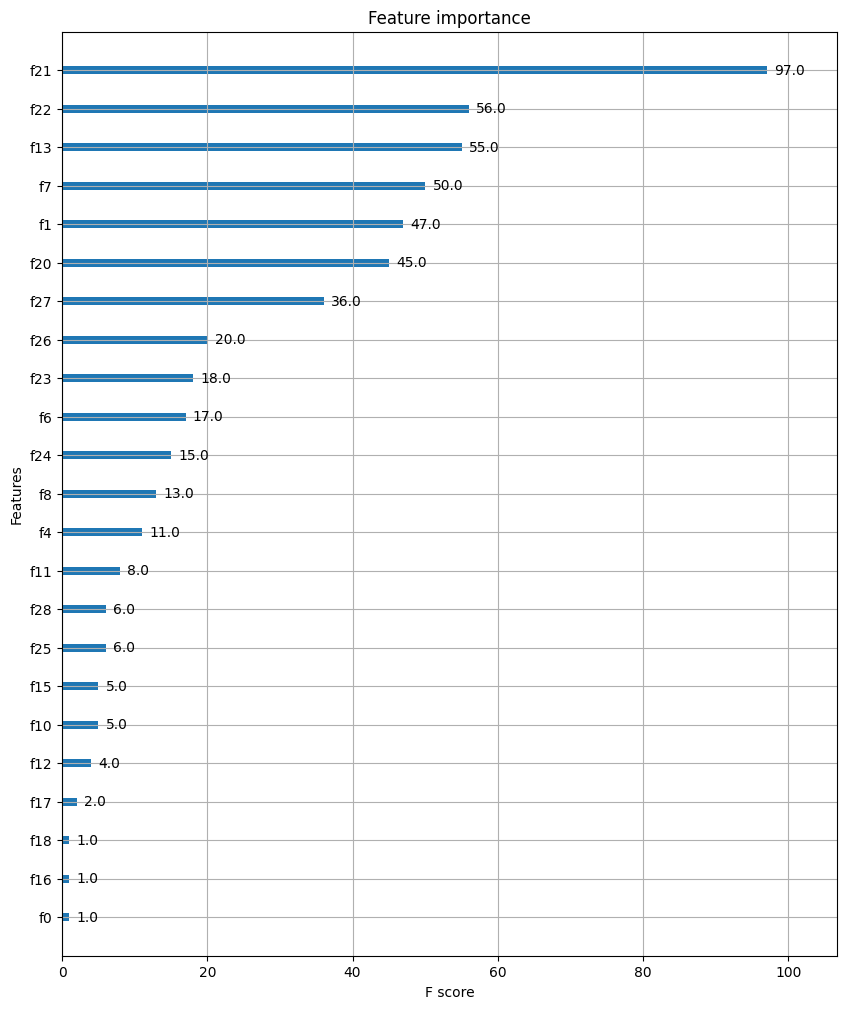

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper, ax=ax)

---
### 07 LightGBM
- XGboost에서 GridSearchCV로 하이퍼 파라미터 튜닝을 수행하다 보면, 수행 시간이 너무 오래 걸려서 어려움을 겪을 수 있음.